#### Initalizing Variables and Preprocessing Datasets

##### Packages

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_wavelets.Layers.DWT as wavelet
from keras.preprocessing.image import ImageDataGenerator

##### Constents

In [2]:
TRAIN_DATA_PATH = "Data/train"
VALID_DATA_PATH = "Data/valid"
TEST_DATA_PATH  = "Data/test"
BATCH_SIZE      = 16
TARGET_SIZE     = (227,227)
INPUT_SHAPE     = [227,227,3]

##### Data Preprocessing

###### Training Data Preprocessing

In [3]:
train_data_generator = tf.keras.preprocessing.image.ImageDataGenerator( rescale = 1.0/255.0,
                                                                        horizontal_flip = True,
                                                                        fill_mode = 'nearest',
                                                                        zoom_range=0.2,
                                                                        shear_range = 0.2,
                                                                        width_shift_range=0.2,
                                                                        height_shift_range=0.2,
                                                                        rotation_range=0.4)

train_data = train_data_generator.flow_from_directory(  TRAIN_DATA_PATH,
                                                        batch_size = BATCH_SIZE,
                                                        target_size = TARGET_SIZE,
                                                        class_mode = 'categorical')

Found 613 images belonging to 4 classes.


###### Validation Data Preprocessing

In [4]:
validation_data_generator = ImageDataGenerator(rescale = 1.0/255.0)

validation_data = validation_data_generator.flow_from_directory(     VALID_DATA_PATH,
                                                        target_size = TARGET_SIZE,
                                                        batch_size = BATCH_SIZE,
                                                        class_mode = 'categorical')

Found 72 images belonging to 4 classes.


#### Initalizing Convolutional Neural Networks

##### Abstract Class

In [5]:
class CNNModel:
    def __init__(self, input_shape=0, model_type='', model_path=None):
        self.model_type = model_type
        self.history = None
        self.history_accuracy = []
        self.history_val_accuracy = []
        self.history_loss = []
        self.history_val_loss = []
        self.input_shape = input_shape
        self.model = tf.keras.models.Sequential()
        if(model_path==None):
            self.model_path = 'savedModel/CNNModel.ckpt'
        else:
            self.model_path = model_path
        self.model_checkpoint = tf.keras.callbacks.ModelCheckpoint(self.model_path,save_weights_only=True,verbose=1)

    def fit(self,train_data, validation_data, epochs):
        self.history = self.model.fit(x = train_data, validation_data = validation_data, epochs = epochs, callbacks=[self.model_checkpoint])
        self.history_accuracy.extend(self.history.history['accuracy'])
        self.history_val_accuracy.extend(self.history.history['val_accuracy'])
        self.history_loss.extend(self.history.history['loss'])
        self.history_val_loss.extend(self.history.history['val_loss'])

    def plotAccuracy(self):
        if(self.history != None):
            print(self.history.history.keys())
            plt.plot(self.history_accuracy)
            plt.plot(self.history_val_accuracy)
            plt.title('model accuracy')
            plt.ylabel('accuracy')
            plt.xlabel('epoch')
            plt.legend(['train','test'], loc='upper left')
            plt.show()
        
    def plotLoss(self):
        if(self.history != None):
            plt.plot(self.history_loss)
            plt.plot(self.history_val_loss)
            plt.title('model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'test'], loc='upper left')
            plt.show()

    def compareAccuracy(models):
        modelList = []
        for model in models:
            if(model.history != None):
                plt.plot(model.history_accuracy)
                modelList.append(model.model_type)
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(modelList, loc='upper left')
        plt.show()

    def compareLoss(models):
        modelList = []
        for model in models:
            if(model.history != None):
                plt.plot(model.history_loss)
                modelList.append(model.model_type)
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(modelList, loc='upper left')
        plt.show()

    def predict(self, path):
        classes_dir = ["Adenocarcinoma","Large cell carcinoma","Normal","Squamous cell carcinoma"]
        image = tf.keras.utils.load_img(path, target_size=TARGET_SIZE)
        normalizedImage = tf.keras.utils.img_to_array(image)/255
        imageArray = np.array([normalizedImage])
        predtionResult = np.argmax(self.model.predict(imageArray))
        print(classes_dir[predtionResult])

    def load(self,model_path=None):
        if(model_path==None):
            self.model.load_weights(self.model_path)
        else:
            self.model.load_weights(model_path)
            
    def summary(self):
        print(self.model.summary())

##### LeNet

In [30]:
class LeNet(CNNModel):
    def __init__(self,input_shape=0,model_path='savedModel/LeNet.ckpt'):

        super().__init__(input_shape=input_shape,model_type="LeNet",model_path=model_path)
        self.model.add(tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation='tanh', strides=1, input_shape=input_shape, padding="same"))
        self.model.add(tf.keras.layers.AveragePooling2D(pool_size=2,strides=2, padding="valid"))
        
        self.model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=1, activation='tanh', padding="valid"))
        self.model.add(tf.keras.layers.AveragePooling2D(pool_size=2,strides=2, padding="valid"))
        
        self.model.add(tf.keras.layers.Flatten())
        self.model.add(tf.keras.layers.Dense(units=120, activation='tanh'))
        self.model.add(tf.keras.layers.Dense(units=84, activation='tanh'))
        self.model.add(tf.keras.layers.Dense(units=4, activation='softmax'))
        self.model.compile(loss='categorical_crossentropy', optimizer="rmsprop", metrics = ['accuracy'])

##### AlexNet

In [7]:
class AlexNet(CNNModel):
    def __init__(self,input_shape=0,model_path='savedModel/AlexNet.ckpt'):

        super().__init__(input_shape=input_shape,model_type="AlexNet",model_path=model_path)
        self.model.add(tf.keras.layers.Conv2D(filters=96, kernel_size=11, activation='relu', strides=4, input_shape=input_shape))
        self.model.add(tf.keras.layers.MaxPool2D(pool_size=3,strides=2))
        self.model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=5, activation='relu'))
        self.model.add(tf.keras.layers.MaxPool2D(pool_size=3,strides=2))
        self.model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=3, activation='relu'))
        self.model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=3, activation='relu'))
        self.model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=3, activation='relu'))
        self.model.add(tf.keras.layers.MaxPool2D(pool_size=3,strides=2))
        self.model.add(tf.keras.layers.Flatten())
        self.model.add(tf.keras.layers.Dense(units=4096, activation='relu'))
        self.model.add(tf.keras.layers.Dropout(0.5))
        self.model.add(tf.keras.layers.Dense(units=4096, activation='relu'))
        self.model.add(tf.keras.layers.Dropout(0.5))
        self.model.add(tf.keras.layers.Dense(units=4, activation='softmax'))
        self.model.compile(loss='categorical_crossentropy', optimizer="sgd", metrics = ['accuracy'])

##### Wavelet AlexNet

In [8]:
class WaveletAlexNet(CNNModel):
    def __init__(self,input_shape=0,model_path='savedModel/WaveletAlexNet.ckpt'):


        super().__init__(input_shape=input_shape,model_type="WaveletAlexNet",model_path=model_path)
        self.model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=5, activation='relu', strides=4, input_shape=input_shape))

        self.model.add(wavelet.DWT(name='bd2'))
        self.model.add(tf.keras.layers.Reshape((112, 112, 96)))

        self.model.add(tf.keras.layers.MaxPool2D(pool_size=3,strides=2))
        self.model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=5, activation='relu'))
        self.model.add(tf.keras.layers.MaxPool2D(pool_size=3,strides=2))
        self.model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=3, activation='relu'))
        self.model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=3, activation='relu'))
        self.model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=3, activation='relu'))
        self.model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=3, activation='relu'))
        self.model.add(tf.keras.layers.MaxPool2D(pool_size=3,strides=2))
        self.model.add(tf.keras.layers.Flatten(input_shape = (2,2,384)))
        self.model.add(tf.keras.layers.Dense(units=4096, activation='relu'))
        self.model.add(tf.keras.layers.Dropout(0.5))
        self.model.add(tf.keras.layers.Dense(units=4096, activation='relu'))
        self.model.add(tf.keras.layers.Dropout(0.5))
        self.model.add(tf.keras.layers.Dense(units=4, activation='softmax'))
        self.model.compile(loss='categorical_crossentropy', optimizer="sgd", metrics = ['accuracy'])

##### ResNet

In [9]:
class ResNet(CNNModel):
    def __init__(self,input_shape=0,model_path='savedModel/ResNet.h5'):
        if(input_shape==0):
            super().__init__(input_shape=input_shape,model_type="ResNet",model_path=model_path)
        else:
            super().__init__(input_shape=input_shape,model_type="ResNet")
            pretrained_model= tf.keras.applications.ResNet50(include_top=False,
            input_shape=INPUT_SHAPE,
            pooling='avg',classes=5,
            weights='imagenet')

        for layer in pretrained_model.layers:
            layer.trainable=True

        self.model.add(pretrained_model)
        self.model.add(tf.keras.layers.Flatten())
        self.model.add(tf.keras.layers.Dense(512, activation='relu'))
        self.model.add(tf.keras.layers.Dense(4, activation='softmax'))
        self.model.compile(loss='categorical_crossentropy', optimizer="sgd", metrics = ['accuracy'])
            

##### Modified ResNet

In [10]:
class HybridResNet(CNNModel):
    def __init__(self,input_shape=0,model_path='savedModel/HybridResNet.h5'):
        if(input_shape==0):
            super().__init__(input_shape=input_shape,model_type="HybridResNet",model_path=model_path)
        else:
            super().__init__(input_shape=input_shape,model_type="HybridResNet")
            pretrained_model= tf.keras.applications.ResNet50(include_top=False,
            input_shape=INPUT_SHAPE,
            pooling='max',classes=5,
            weights='imagenet')

        for layer in pretrained_model.layers:
            layer.trainable=True

        self.model.add(pretrained_model)
        self.model.add(tf.keras.layers.Flatten())
        self.model.add(tf.keras.layers.Dense(512, activation='relu'))
        self.model.add(tf.keras.layers.Dense(4, activation='softmax'))
        self.model.compile(loss='categorical_crossentropy', optimizer="sgd", metrics = ['accuracy'])

#### MAIN

##### Initialize Mode

In [11]:
alexNet = AlexNet(INPUT_SHAPE)

In [32]:
leNet = LeNet(INPUT_SHAPE)

In [13]:
waveletAlexNet = WaveletAlexNet(INPUT_SHAPE)

In [14]:
resNet = ResNet(INPUT_SHAPE)

##### Summary Mode

In [15]:
leNet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 227, 227, 6)       456       
                                                                 
 average_pooling2d (AverageP  (None, 113, 113, 6)      0         
 ooling2D)                                                       
                                                                 
 conv2d_6 (Conv2D)           (None, 109, 109, 16)      2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 54, 54, 16)       0         
 ePooling2D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 46656)             0         
                                                                 
 dense_3 (Dense)             (None, 120)              

In [16]:
resNet.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_9 (Dense)             (None, 512)               1049088   
                                                                 
 dense_10 (Dense)            (None, 4)                 2052      
                                                                 
Total params: 24,638,852
Trainable params: 24,585,732
Non-trainable params: 53,120
_________________________________________________________________
None


##### Training Modes

In [33]:
leNet.fit(train_data, validation_data, 256)

Epoch 1/256
39/39 [==============================] - ETA: 0s - loss: 1.5552 - accuracy: 0.2675
Epoch 1: saving model to savedModel\LeNet.ckpt
39/39 [==============================] - 6s 131ms/step - loss: 1.5552 - accuracy: 0.2675 - val_loss: 1.3645 - val_accuracy: 0.3194
Epoch 2/256
39/39 [==============================] - ETA: 0s - loss: 1.4460 - accuracy: 0.2594
Epoch 2: saving model to savedModel\LeNet.ckpt
39/39 [==============================] - 5s 135ms/step - loss: 1.4460 - accuracy: 0.2594 - val_loss: 1.4303 - val_accuracy: 0.2083
Epoch 3/256
39/39 [==============================] - ETA: 0s - loss: 1.4819 - accuracy: 0.2757
Epoch 3: saving model to savedModel\LeNet.ckpt
39/39 [==============================] - 5s 133ms/step - loss: 1.4819 - accuracy: 0.2757 - val_loss: 1.4176 - val_accuracy: 0.3194
Epoch 4/256
39/39 [==============================] - ETA: 0s - loss: 1.4153 - accuracy: 0.2545
Epoch 4: saving model to savedModel\LeNet.ckpt
39/39 [==============================] 

In [ ]:
resNet.fit(train_data, validation_data, 256)

Epoch 1/256
39/39 [==============================] - ETA: 0s - loss: 0.9423 - accuracy: 0.5742
Epoch 1: saving model to savedModel\CNNModel.ckpt
39/39 [==============================] - 10s 166ms/step - loss: 0.9423 - accuracy: 0.5742 - val_loss: 1.4509 - val_accuracy: 0.3194
Epoch 2/256
39/39 [==============================] - ETA: 0s - loss: 0.6439 - accuracy: 0.7504
Epoch 2: saving model to savedModel\CNNModel.ckpt
39/39 [==============================] - 5s 137ms/step - loss: 0.6439 - accuracy: 0.7504 - val_loss: 1.4085 - val_accuracy: 0.3194
Epoch 3/256
39/39 [==============================] - ETA: 0s - loss: 0.4189 - accuracy: 0.8467
Epoch 3: saving model to savedModel\CNNModel.ckpt
39/39 [==============================] - 5s 136ms/step - loss: 0.4189 - accuracy: 0.8467 - val_loss: 1.3925 - val_accuracy: 0.3194
Epoch 4/256
39/39 [==============================] - ETA: 0s - loss: 0.3190 - accuracy: 0.8907
Epoch 4: saving model to savedModel\CNNModel.ckpt
39/39 [===================

In [ ]:
waveletAlexNet.fit(train_data, validation_data, 256)

Epoch 1/256
39/39 [==============================] - ETA: 0s - loss: 1.3600 - accuracy: 0.3067
Epoch 1: saving model to savedModel\WaveletAlexNet.ckpt
39/39 [==============================] - 9s 184ms/step - loss: 1.3600 - accuracy: 0.3067 - val_loss: 1.4271 - val_accuracy: 0.1806
Epoch 2/256
39/39 [==============================] - ETA: 0s - loss: 1.3383 - accuracy: 0.3148
Epoch 2: saving model to savedModel\WaveletAlexNet.ckpt
39/39 [==============================] - 6s 153ms/step - loss: 1.3383 - accuracy: 0.3148 - val_loss: 1.3987 - val_accuracy: 0.2361
Epoch 3/256
39/39 [==============================] - ETA: 0s - loss: 1.3239 - accuracy: 0.3426
Epoch 3: saving model to savedModel\WaveletAlexNet.ckpt
39/39 [==============================] - 6s 153ms/step - loss: 1.3239 - accuracy: 0.3426 - val_loss: 1.3803 - val_accuracy: 0.3889
Epoch 4/256
39/39 [==============================] - ETA: 0s - loss: 1.3086 - accuracy: 0.3850
Epoch 4: saving model to savedModel\WaveletAlexNet.ckpt
39/

##### Comparing Accuracy


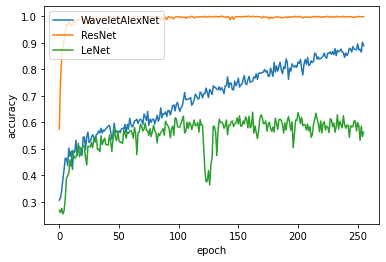

In [34]:
CNNModel.compareAccuracy([waveletAlexNet,resNet,leNet])

##### Comparing Loss

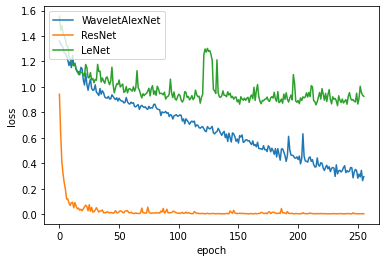

In [35]:
CNNModel.compareLoss([waveletAlexNet,resNet,leNet])

##### Make Prediction

In [ ]:
alexNet.predict("Data/test/adenocarcinoma/000114.png")

1/1 [==============================] - 0s 13ms/step
Squamous cell carcinoma


In [ ]:
waveletAlexNet.predict("Data/test/adenocarcinoma/000114.png")

1/1 [==============================] - 0s 26ms/step
Squamous cell carcinoma


In [ ]:
resNet.predict("Data/test/adenocarcinoma/000114.png")

1/1 [==============================] - 0s 15ms/step
Adenocarcinoma


##### Models History Accuracy

In [ ]:
print(resNet.history_accuracy)

[0.5970636010169983, 0.7862969040870667, 0.8352365493774414, 0.9070146679878235, 0.9021207094192505, 0.9070146679878235, 0.9690048694610596, 0.9592169523239136, 0.975530207157135, 0.9738988876342773, 0.9690048694610596, 0.980424165725708, 0.9787928462028503, 0.975530207157135, 0.9885807633399963, 0.975530207157135, 0.990212082862854, 0.990212082862854, 0.980424165725708, 0.990212082862854, 0.9836868047714233, 0.985318124294281, 0.9885807633399963, 0.9820554852485657, 0.9918434023857117, 0.985318124294281, 0.9820554852485657, 0.9885807633399963, 0.9918434023857117, 0.995106041431427, 0.9836868047714233, 0.985318124294281, 0.9918434023857117, 0.9934747219085693, 0.9967373609542847, 0.990212082862854, 0.9967373609542847, 0.9934747219085693, 0.995106041431427, 0.995106041431427, 0.995106041431427, 0.9934747219085693, 0.980424165725708, 0.9918434023857117, 0.985318124294281, 0.9918434023857117, 0.9885807633399963, 0.9918434023857117, 0.9934747219085693, 0.9983686804771423, 0.996737360954284

In [ ]:
print(waveletAlexNet.history_accuracy)

[0.27895596623420715, 0.27569329738616943, 0.3425774872303009, 0.404567688703537, 0.42577487230300903, 0.43066883087158203, 0.4600326120853424, 0.5073409676551819, 0.4730831980705261, 0.48939642310142517, 0.5073409676551819, 0.4698205590248108, 0.37357258796691895, 0.3980424106121063, 0.43066883087158203, 0.3931484520435333, 0.4877651035785675, 0.5367047190666199, 0.49592170119285583, 0.5089722871780396, 0.5252854824066162, 0.5318107604980469, 0.5334420800209045, 0.49429038166999817, 0.5350733995437622, 0.5236541628837585, 0.5432299971580505, 0.5530179738998413, 0.5513865947723389, 0.5464926362037659, 0.559543251991272, 0.5530179738998413]


In [ ]:
print(leNet.history_accuracy)

[0.2724306583404541, 0.2528548240661621, 0.26590538024902344, 0.2724306583404541, 0.2969004809856415, 0.28874388337135315, 0.3001631200313568, 0.3099510669708252, 0.3050571084022522, 0.2854812443256378, 0.28384992480278015, 0.2920065224170685, 0.29853180050849915, 0.2903752028942108, 0.3017944395542145, 0.30668842792510986, 0.3017944395542145, 0.30668842792510986, 0.2903752028942108, 0.29363784193992615, 0.31158238649368286, 0.2969004809856415, 0.29853180050849915, 0.3148450255393982, 0.2969004809856415, 0.3230016231536865, 0.3132137060165405, 0.31647634506225586, 0.28874388337135315, 0.3181076645851135, 0.3050571084022522, 0.30342578887939453]


##### Models History Loss

In [ ]:
print(resNet.history_loss)

[]


##### Save to CSV

In [44]:
import csv

with open('accuracy.csv', 'w') as f:

    write = csv.writer(f)

    write.writerow(["ResNet accuracy", "LeNet accuracy", "AlexNet accuracy"])
    
    for x in range(256):
        row = [resNet.history_accuracy[x],leNet.history_accuracy[x],waveletAlexNet.history_accuracy[x]]
        write.writerow(row)


In [ ]:
import csv

with open('loss.csv', 'w') as f:

    write = csv.writer(f)

    write.writerow(["ResNet loss", "LeNet loss", "AlexNet loss"])
    
    for x in range(256):
        row = [resNet.history_loss[x],leNet.history_loss[x],waveletAlexNet.history_loss[x]]
        write.writerow(row)

In [41]:
len(alexNet.history_accuracy)

0